In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *
from tqdm import tqdm 
from ultralytics import RTDETR
from sklearn.metrics import pairwise_distances
from multiprocessing import Pool

In [3]:
fundamental_matrices = {
    "A" : {
        "B": np.load("fundamental_matrices/AB.npy"),
        "C": np.load("fundamental_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("fundamental_matrices/BA.npy"),
        "C": np.load("fundamental_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("fundamental_matrices/CB.npy"),
        "A": np.load("fundamental_matrices/CA.npy"),
    }
}

In [4]:
homography_matrices = {
    "A" : {
        "B": np.load("homography_matrices/AB.npy"),
        "C": np.load("homography_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("homography_matrices/BA.npy"),
        "C": np.load("homography_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("homography_matrices/CB.npy"),
        "A": np.load("homography_matrices/CA.npy"),
    }
}

In [5]:
JUMP_SIZE = 10 

In [6]:
if 'query' in globals():
    del query
if 'reference' in globals():
    del reference

query = load_video("train/task1/10_query.mp4")
reference = load_video("train/task1/10_reference.mp4")

In [7]:
camera_query = query.get_camera()
camera_reference = reference.get_camera()

print("Query camera:", camera_query)
print("Reference camera:", camera_reference)

Query camera: C
Reference camera: A


In [8]:
F = fundamental_matrices[camera_query][camera_reference] 
print(F)
F_inv = fundamental_matrices[camera_reference][camera_query] 
print(F_inv)

[[-5.7527e-07 -9.7317e-06    0.003172]
 [ 5.5402e-06  7.1693e-06   0.0029729]
 [ -0.0003995  -0.0036525           1]]
[[-5.7527e-07  5.5402e-06  -0.0003995]
 [-9.7317e-06  7.1693e-06  -0.0036525]
 [   0.003172   0.0029729           1]]


In [9]:
H = homography_matrices[camera_query][camera_reference]
print(H)
H_inv = homography_matrices[camera_reference][camera_query]
print(H_inv)

[[    0.82196     -1.7032      4155.6]
 [   -0.14479      2.8583     -238.45]
 [-0.00067971   0.0035915           1]]
[[     -4.734     -25.259       17296]
 [   -0.76251     -7.9624      3239.4]
 [ -0.0020016  -0.0028567           1]]


In [10]:
query.compute_moving_pixels()
reference.compute_moving_pixels()

In [11]:
query_index = 1 
reference_index = 760 

In [12]:
def similarity_epipolar(query, reference, F, H, H_inv, visualize=False):
    moving_pixels_query = query.moving_pixels()
    moving_pixels_reference = reference.moving_pixels()

    # Get the actual coordinates of the moving pixels
    rows, cols = np.where(moving_pixels_query)
    points_query = np.stack((cols, rows), axis=1) 

    rows, cols = np.where(moving_pixels_reference)
    points_reference = np.stack((cols, rows), axis=1) 

    if len(points_query) == 0 or len(points_reference) == 0:
        return None

    # Filter points that would be outside the frame when transformed to the other camera's frame.
    points_query = filter_points_homography(points_query, H)
    points_reference = filter_points_homography(points_reference, H_inv)

    if len(points_query) == 0 or len(points_reference) == 0:
        return None

    # Downsample points to avoid too many points
    if len(points_query) > 6000:
        indices = np.random.choice(len(points_query), 6000, replace=False)
        points_query = points_query[indices]

    if len(points_reference) > 6000:
        indices = np.random.choice(len(points_reference), 6000, replace=False)
        points_reference = points_reference[indices]

    # Compute the epipolar lines for the query points in the reference frame.
    lines = cv.computeCorrespondEpilines(points_query.reshape(-1, 1, 2), 1, F).squeeze()
    score = 0

    # Just prepare the plots if visualization is enabled.
    if visualize:
        query_plot = query.raw().copy()
        reference_plot = reference.raw().copy()

    chosen = np.zeros(len(points_reference), dtype=bool)
    for i, line in enumerate(lines):
        distances = distance_point_to_line(points_reference, line)
        distances[chosen] = np.inf  # Ignore already chosen points

        minimum_index = np.argmin(distances)
        minimum_distance = distances[minimum_index]

        if minimum_distance < 5:
            score+=1

            # Mark this point as chosen so we don't use it again.
            chosen[minimum_index] = True

            if visualize:
                color = np.random.randint(0, 255, size=3).tolist()
                cv.circle(query_plot, (points_query[i][0], points_query[i][1]), 10, color, -1)
                close_point = points_reference[minimum_index]
                cv.circle(reference_plot, (close_point[0], close_point[1]), 10, color, -1)
                draw_epiline(line, reference_plot, color=color) 
    
    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(20, 30))
        axs[0].imshow(moving_pixels_query)
        axs[1].imshow(moving_pixels_reference)
        plt.show()
        
        fig, axs = plt.subplots(1, 2, figsize=(20, 30))
        axs[0].imshow(query_plot)
        axs[0].set_title("Query Frame")
        axs[0].axis('off')
        axs[1].imshow(reference_plot)
        axs[1].set_title("Reference Frame")
        axs[1].axis('off')
        plt.show()

    return score

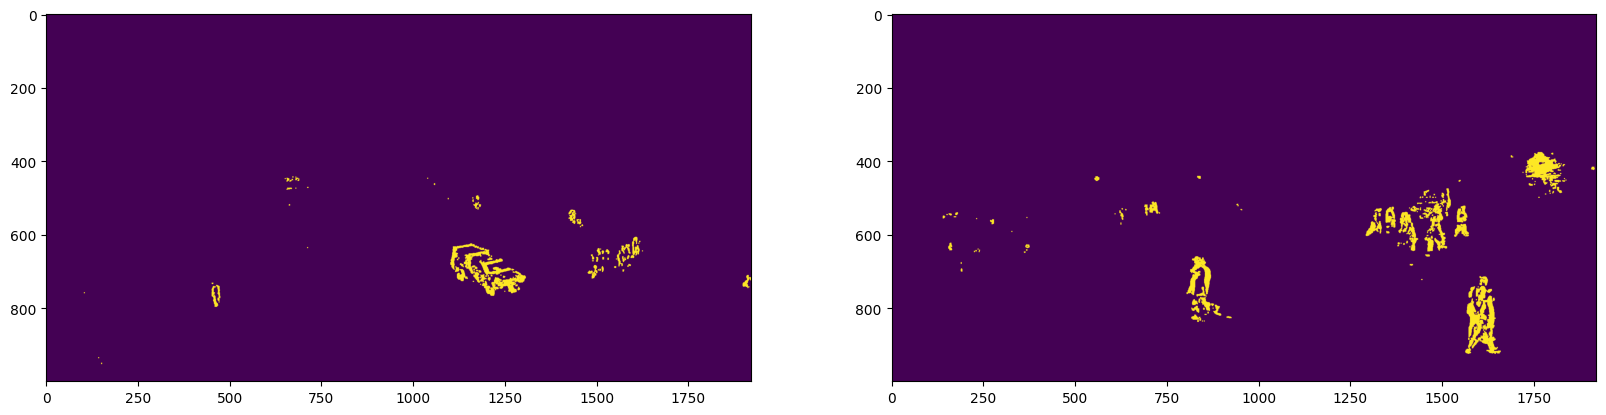

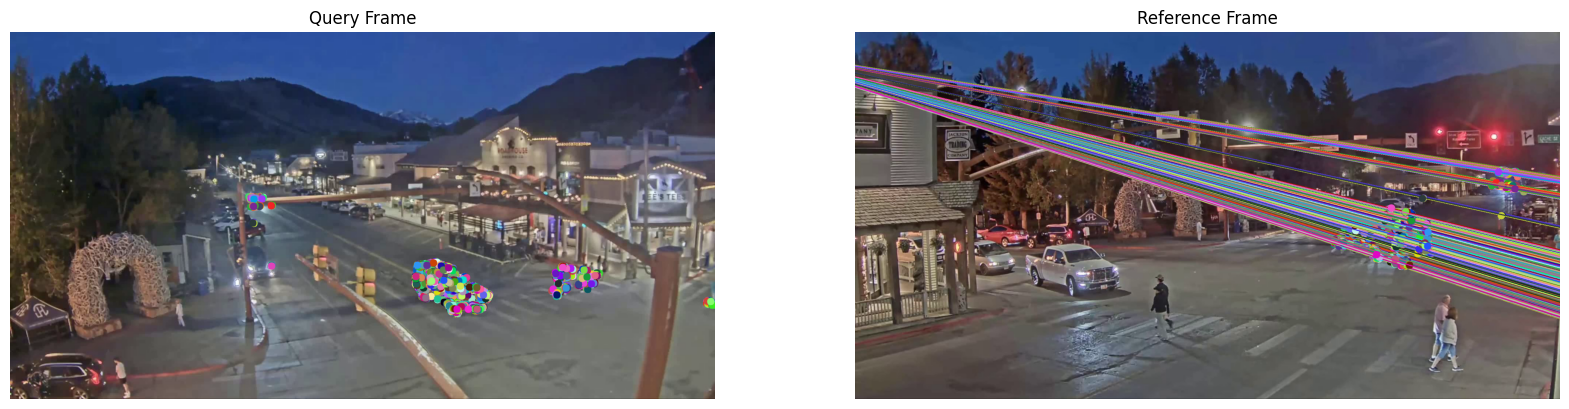

3412


In [13]:
similarity_score = similarity_epipolar(query.get_frame(query_index), reference.get_frame(reference_index), F, H, H_inv,
                              visualize=True)
print(similarity_score)

In [14]:
def overlap_score(reference_start_index):
    num_query_frames = query.num_frames()
    score = 0
    for t in range(0, num_query_frames, JUMP_SIZE):
        query_frame = query.get_frame(t)
        reference_frame = reference.get_frame(reference_start_index + t)

        cost = similarity_epipolar(query_frame, reference_frame, F, H, H_inv)
        if cost is not None:
            score += cost

    return (reference_start_index, score)

In [15]:
num_query_frames = query.num_frames()
num_reference_frames = reference.num_frames()
print(num_query_frames)
costs = []

with Pool() as pool:
    starts = range(0, num_reference_frames-num_query_frames+1, 10)
    results = list(tqdm(pool.imap(overlap_score, starts), total=len(starts)))

180


100%|██████████| 162/162 [00:55<00:00,  2.92it/s]


[(0, 48713), (10, 50731), (20, 52276), (30, 53903), (40, 54390), (50, 53985), (60, 53314), (70, 51835), (80, 49665), (90, 47485), (100, 44856), (110, 41826), (120, 38441), (130, 35271), (140, 32446), (150, 29620), (160, 27029), (170, 24580), (180, 22849), (190, 21688), (200, 20924), (210, 20643), (220, 20740), (230, 21119), (240, 22130), (250, 23162), (260, 24254), (270, 25662), (280, 27504), (290, 29122), (300, 31380), (310, 33389), (320, 35114), (330, 37723), (340, 39323), (350, 40646), (360, 41701), (370, 43424), (380, 44489), (390, 45823), (400, 46652), (410, 47445), (420, 48111), (430, 49521), (440, 50223), (450, 51362), (460, 51643), (470, 52544), (480, 52490), (490, 52958), (500, 52234), (510, 52853), (520, 52913), (530, 53612), (540, 53729), (550, 54510), (560, 54787), (570, 54972), (580, 54918), (590, 54895), (600, 54531), (610, 54400), (620, 54995), (630, 55159), (640, 55543), (650, 55777), (660, 55121), (670, 56686), (680, 56036), (690, 55308), (700, 54799), (710, 54007), (7

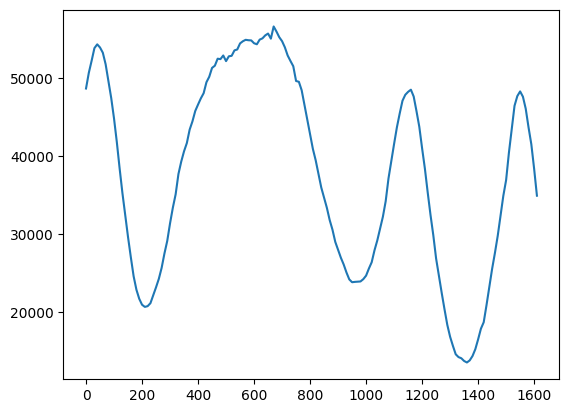

In [17]:
print(results)
plt.plot([result[0] for result in results], [result[1] for result in results])

argmax = np.argmax([result[1] for result in results])
print(results[argmax])